<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-+-Constants" data-toc-modified-id="Imports-+-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports + Constants</a></span></li><li><span><a href="#Look-at-LSMS-Locs" data-toc-modified-id="Look-at-LSMS-Locs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Look at LSMS Locs</a></span><ul class="toc-item"><li><span><a href="#Get-lat/lon-info" data-toc-modified-id="Get-lat/lon-info-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Get lat/lon info</a></span></li></ul></li><li><span><a href="#Inspect-TFRecords" data-toc-modified-id="Inspect-TFRecords-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inspect TFRecords</a></span></li><li><span><a href="#Process-TFRecords" data-toc-modified-id="Process-TFRecords-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Process TFRecords</a></span></li><li><span><a href="#Verify-TFRecords" data-toc-modified-id="Verify-TFRecords-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Verify TFRecords</a></span></li></ul></div>

Inspects and processes LSMS data. Inputs are:
- CSV: columns are `[lat, lon, year, country, index, ea_id]`
- TFRecords: 3-year Landsat 5/7/8 composites, with DMSP (pre-2012) or VIIRS (2012 or after) nightlights

Verifies that the fields in the TFRecords match the CSV.

Splits each monolithic TFRecord file exported from Google Earth Engine into one file per record.

# Imports + Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
import os
from pprint import pprint
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

sys.path.append('/atlas/u/chrisyeh/africa_poverty')
from batchers import batcher, dataset_constants
from preprocessing.helper import get_first_feature_map, get_feature_types
from utils.run import run_epoch
from utils.plot import plot_image_by_band

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

DATASET_NAME = 'LSMS'
BAND_KEYS = ['RED', 'BLUE', 'GREEN', 'SWIR1', 'TEMP1', 'SWIR2', 'NIR', 'NIGHTLIGHTS']

MEANS = dataset_constants.MEANS_DICT[DATASET_NAME]
STD_DEVS = dataset_constants.STD_DEVS_DICT[DATASET_NAME]

out_root_dir = '/atlas/u/chrisyeh/poverty_data/lsms'

# Look at LSMS Locs

In [4]:
# file that Anne sent to me
LSMS_CSV_PATH = '/atlas/u/chrisyeh/africa_poverty/data/lsms_labels_agg.csv'
lsms_df = pd.read_csv(LSMS_CSV_PATH, float_precision='high')
lsms_df['lat'] = lsms_df['lat'].astype(np.float32)
lsms_df['lon'] = lsms_df['lon'].astype(np.float32)
lsms_df['index'] = lsms_df['index'].astype(np.float32)
print(lsms_df.dtypes)

with pd.option_context('display.max_rows', 8):
    display(lsms_df)

lat        float32
lon        float32
year         int64
country     object
index      float32
ea_id        int64
dtype: object


,lat,lon,year,country,index,ea_id
0,-0.292248,31.478722,2005,ug,0.045405,1110003
1,-0.292248,31.478722,2009,ug,-0.333650,1110003
2,-0.292248,31.478722,2013,ug,-0.386531,1110003
3,-0.439120,31.711950,2005,ug,0.310049,0
...,...,...,...,...,...,...
3016,9.917938,11.689417,2010,ng,-0.688097,590
3017,9.917938,11.689417,2015,ng,0.119982,590
3018,9.991906,37.692554,2011,et,-1.261734,3061102207
3019,9.991906,37.692554,2015,et,-1.187214,3061102207


In [5]:
cid_to_c = {
    'et': 'ethiopia',
    'mw': 'malawi',
    'ng': 'nigeria',
    'tz': 'tanzania',
    'ug': 'uganda',
}
c_to_cid = {c: cid for c, cid in cid_to_c.items()}

## Get lat/lon info

In [6]:
# (lat, lon) => (cid, [list of years])
loc_info = {}

for name, group in lsms_df.groupby(['lat', 'lon']):
    loc = tuple(np.float32(name))
    cids = group['country'].unique()
    assert len(cids) == 1
    cid = cids[0]
    years = sorted(group['year'].unique())
    loc_info[loc] = (cid, years)

In [7]:
locs_df = lsms_df.groupby(['lat', 'lon', 'country']).size().index.to_frame(index=False)

with pd.option_context('display.max_rows', 4):
    display(locs_df)

,lat,lon,country
0,-16.985500,35.249901,mw
1,-16.600000,34.967300,mw
...,...,...,...
1455,14.353816,37.890877,et
1456,14.455961,39.479084,et


In [8]:
def get_lat(lon, cid):
    rows = locs_df.loc[(locs_df['lon'] == lon) & (locs_df['country'] == cid)]
    assert len(rows) == 1
    return rows.iloc[0]['lat']

# Inspect TFRecords

In [9]:
tfrecord_path = '/atlas/u/chrisyeh/poverty_data/lsms_orig/lx_median_2003-05_lsmslocs_ee_export.tfrecord.gz'
feature_map = get_first_feature_map(tfrecord_path)
feature_types = get_feature_types(feature_map)

print(f'TFRecord path: {tfrecord_path}')
print('Features and types:')
pprint(feature_types)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
TFRecord path: /atlas/u/chrisyeh/poverty_data/lsms_orig/lx_median_2003-05_lsmslocs_ee_export.tfrecord.gz
Features and types:
{'BLUE': ('float_list', (65025,)),
 'GREEN': ('float_list', (65025,)),
 'LAT': ('float_list', (65025,)),
 'LON': ('float_list', (65025,)),
 'NIGHTLIGHTS': ('float_list', (65025,)),
 'NIR': ('float_list', (65025,)),
 'RED': ('float_list', (65025,)),
 'SWIR1': ('float_list', (65025,)),
 'SWIR2': ('float_list', (65025,)),
 'TEMP1': ('float_list', (65025,)),
 'country': ('bytes_list', (1,)),
 'ea_id': ('float_list', (1,)),
 'id': ('float_list', (1,)),
 'index': ('float_list', (1,)),
 'lon': ('float_list', (1,)),
 'system:index': ('bytes_list', (1,)),
 'year': ('float_list', (1,))}


In [10]:
tfrecord_path = '/atlas/u/chrisyeh/poverty_data/lsms_orig/lx_median_2009-11_lsmslocs_ee_export.tfrecord.gz'
feature_map = get_first_feature_map(tfrecord_path)
feature_types = get_feature_types(feature_map)

print(f'TFRecord path: {tfrecord_path}')
print('Features and types:')
pprint(feature_types)

TFRecord path: /atlas/u/chrisyeh/poverty_data/lsms_orig/lx_median_2009-11_lsmslocs_ee_export.tfrecord.gz
Features and types:
{'BLUE': ('float_list', (65025,)),
 'GREEN': ('float_list', (65025,)),
 'LAT': ('float_list', (65025,)),
 'LON': ('float_list', (65025,)),
 'NIGHTLIGHTS': ('float_list', (65025,)),
 'NIR': ('float_list', (65025,)),
 'RED': ('float_list', (65025,)),
 'SWIR1': ('float_list', (65025,)),
 'SWIR2': ('float_list', (65025,)),
 'TEMP1': ('float_list', (65025,)),
 'country': ('bytes_list', (1,)),
 'ea_id': ('float_list', (1,)),
 'id': ('float_list', (1,)),
 'index': ('float_list', (1,)),
 'lon': ('float_list', (1,)),
 'system:index': ('bytes_list', (1,)),
 'year': ('float_list', (1,))}


Location: (7.957733, 3.150731), nigeria
2010


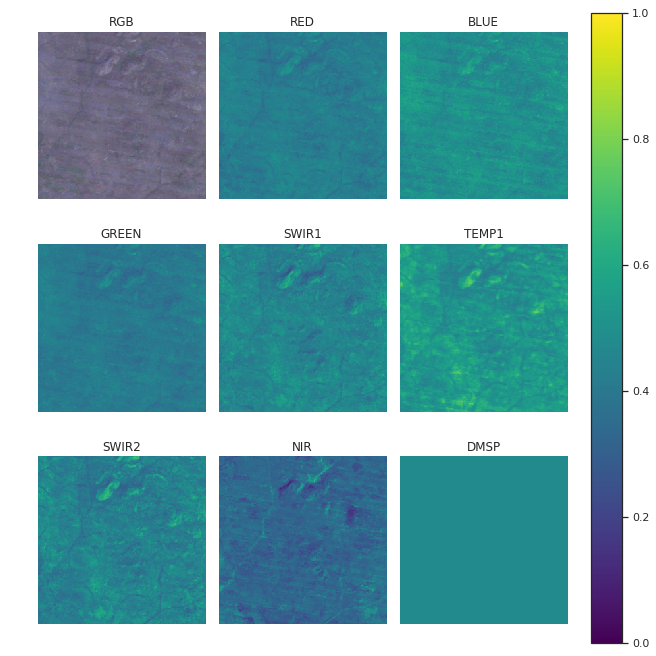

In [11]:
def year_to_nltype(year):
    return 'DMSP' if year < 2012 else 'VIIRS'

def band_keys_for_year(band_keys, year):
    '''
    Args
    - band_keys: list of str, including 'NIGHTLIGHTS'
    - year: numeric

    Returns
    - new_band_keys: copy of band_keys with 'NIGHTLIGHTS' replaced by 'DMSP' or 'VIIRS'
    '''
    new_band_keys = list(band_keys) # make a local copy
    new_band_keys[band_keys.index('NIGHTLIGHTS')] = year_to_nltype(year)
    return new_band_keys

def plot_single_img(feature_map):
    feature_map = get_first_feature_map(tfrecord_path)
    lon = np.float32(feature_map['lon'].float_list.value[0])
    cid = feature_map['country'].bytes_list.value[0].decode()
    lat = get_lat(lon=lon, cid=cid)
    country = cid_to_c[cid]
    fig_title = f'Location: ({lat:.6f}, {lon:.6f}), {country}'
    print(fig_title)
    year = int(feature_map['year'].float_list.value[0])
    print(year)

    # choose 'DMSP' or 'VIIRS' for nightlights band name based on year
    band_keys_nl = band_keys_for_year(BAND_KEYS, year)

    img_normalized = []
    for b_idx, b_name in enumerate(BAND_KEYS):
        band = np.array(feature_map[b_name].float_list.value, dtype=np.float32).reshape(255, 255)
        b = band_keys_nl[b_idx]
        band = (band - MEANS[b]) / STD_DEVS[b]
        img_normalized.append(band)
    img_normalized = np.stack(img_normalized, axis=2)
    plot_image_by_band(img=img_normalized, band_order=band_keys_nl, nrows=3, title='',
                       rgb='add', colorbar=True)


plot_single_img(feature_map)

# Process TFRecords

In [12]:
REQUIRED_KEYS = [
    'BLUE', 'GREEN', 'LAT', 'LON', 'NIGHTLIGHTS', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'TEMP1',
    'lon', 'year', 'index', 'ea_id', 'country'
]

NON_NEGATIVE_BANDS = ['RED', 'BLUE', 'GREEN', 'NIGHTLIGHTS', 'NIR', 'SWIR1', 'SWIR2', 'TEMP1']

def validate_example(feature_map, record_num, year_range):
    '''
    Args
    - feature_map: protobuf map from feature name strings to Feature
    - record_num: int
    - year_range: tuple (int, int), feature_map['year'] should be within year_range inclusive

    Returns:
    - False if example is invalid
    - (lat, lon, year) if example is valid
    '''
    def print_info():
        info = {}
        if 'lon' in feature_map:
            info['lon'] = np.float32(feature_map['lon'].float_list.value[0])
        if 'year' in feature_map:
            info['year'] = int(feature_map['year'].float_list.value[0])
        print(f'  {info}')  # indented print

    missing_req_keys = [key for key in REQUIRED_KEYS if key not in feature_map]
    if len(missing_req_keys) > 0:
        print(f'Record {record_num} missing required keys: {missing_req_keys}')
        print_info()
        return False

    year = int(feature_map['year'].float_list.value[0])
    if (year < year_range[0]) or (year > year_range[1]):
        print(f'Record {record_num} has invalid year {year}')
        print_info()
        return False

    lon = np.float32(feature_map['lon'].float_list.value[0])
    cid = feature_map['country'].bytes_list.value[0].decode()
    lat = get_lat(lon=lon, cid=cid)

    img_lon = np.float32(np.asarray(feature_map['LON'].float_list.value).reshape(255, 255)[127, 127])
    img_lat = np.float32(np.asarray(feature_map['LAT'].float_list.value).reshape(255, 255)[127, 127])

    if abs(lon - img_lon) > 1e-3:
        print(f'Record {record_num} contains mismatch: "lon"={lon}, "LON"={img_lon}')
        print_info()
        return False
    if abs(lat - img_lat) > 1e-3:
        print(f'Record {record_num} contains invalid lat. "lat"={lat}, "LAT"={img_lat}')
        print_info()
        return False
    feature_map['lat'].float_list.value.append(lat)

    negative_bands = [band for band in NON_NEGATIVE_BANDS if contains_neg(feature_map, band)]
    if len(negative_bands) > 0:
        print(f'Record {record_num} contains negative bands: {negative_bands}')
        for band in negative_bands:
            count = np.sum(np.asarray(feature_map[band].float_list.value) < 0)
            min_val = np.float32(np.min(feature_map[band].float_list.value))
            print(f'  Band "{band}" - count: {count}, min value: {min_val}')
        print_info()

    # rename 'index' => 'wealthpooled'
    wealthpooled = feature_map.pop('index').float_list.value[0]
    feature_map['wealthpooled'].float_list.value.append(wealthpooled)

    return (lat, lon, year)

def contains_neg(feature_map, band):
    '''
    Args
    - feature_map
    - band: str, key for a float_list feature in feature_map

    Returns: bool, True iff feature_map[band] contains negative values
    '''
    arr = np.asarray(feature_map[band].float_list.value)
    return np.any(arr < 0)

def process_tfrecord(tfrecord_path, out_root_dir, year_range):
    '''
    Args
    - tfrecord_path: str, path to TFrecord file
    - out_root_dir: str, path to dir to save processed individual TFRecords
    - year_range: tuple (int, int), start and end year (inclusive) of the imagery contained in the tfrecord
    '''
    # Create an iterator over the TFRecords file. The iterator yields
    # the binary representations of Example messages as strings.
    options = tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.GZIP)
    iterator = tf.io.tf_record_iterator(tfrecord_path, options=options)

    num_good_records = 0
    for record_idx, record_str in enumerate(iterator):
        # parse the binary string
        ex = tf.train.Example.FromString(record_str)  # parse into an actual Example message
        features = ex.features  # get the Features message within the Example
        feature_map = features.feature  # get the mapping from feature name strings to Feature

        is_valid_record = validate_example(feature_map, record_idx, year_range)

        if is_valid_record != False:
            lat, lon, year = is_valid_record

            cid, years = loc_info[(lat, lon)]
            assert year in years
            country = cid_to_c[cid]

            country_year = f'{country}_{year}'
            out_dir = os.path.join(out_root_dir, country_year)
            out_path = os.path.join(out_dir, f'{num_good_records}.tfrecord.gz')

            # serialize to string and write to file
            os.makedirs(out_dir, exist_ok=True)
            with tf.io.TFRecordWriter(out_path, options=options) as writer:
                writer.write(ex.SerializeToString())
            num_good_records += 1

        if (record_idx + 1) % 50 == 0:
            print(f'Finished validating {record_idx + 1} records')

    print('Finished validating {} records: {} good, {} bad'.format(
        record_idx + 1, num_good_records, record_idx + 1 - num_good_records))

In [13]:
tfrecord_path = '/atlas/u/chrisyeh/poverty_data/lsms_orig/lx_median_2003-05_lsmslocs_ee_export.tfrecord.gz'
year_range = (2003, 2005)
process_tfrecord(tfrecord_path, out_root_dir, year_range)

Finished validating 50 records
Finished validating 100 records
Finished validating 150 records
Finished validating 166 records: 166 good, 0 bad


In [21]:
tfrecord_path = '/atlas/u/chrisyeh/poverty_data/lsms_orig/lx_median_2006-08_lsmslocs_ee_export.tfrecord.gz'
year_range = (2006, 2008)
process_tfrecord(tfrecord_path, out_root_dir, year_range)

Finished validating 0 records
Record 32 contains negative bands: ['SWIR2']
  Band "SWIR2" - count: 1, min value: -0.0015999999595806003
  {'lon': 39.734, 'year': 2008}
Finished validating 50 records
Finished validating 100 records
Finished validating 150 records
Finished validating 200 records
Finished validating 250 records
Finished validating 300 records
Finished validating 350 records
Finished validating 371 records: 371 good, 0 bad


In [25]:
tfrecord_path = '/atlas/u/chrisyeh/poverty_data/lsms_orig/lx_median_2009-11_lsmslocs_ee_export.tfrecord.gz'
year_range = (2009, 2011)
process_tfrecord(tfrecord_path, out_root_dir, year_range)

Finished validating 50 records
Finished validating 100 records
Record 108 contains negative bands: ['SWIR2']
  Band "SWIR2" - count: 1, min value: -0.014700000174343586
  {'lon': 6.619414, 'year': 2010}
Finished validating 150 records
Finished validating 200 records
Finished validating 250 records
Finished validating 300 records
Finished validating 350 records
Finished validating 400 records
Finished validating 450 records
Finished validating 500 records
Finished validating 550 records
Finished validating 600 records
Finished validating 650 records
Finished validating 700 records
Finished validating 750 records
Finished validating 800 records
Finished validating 850 records
Finished validating 900 records
Finished validating 950 records
Finished validating 1000 records
Finished validating 1050 records
Finished validating 1077 records: 1077 good, 0 bad


In [26]:
tfrecord_path = '/atlas/u/chrisyeh/poverty_data/lsms_orig/lx_median_2012-14_lsmslocs_ee_export.tfrecord.gz'
year_range = (2012, 2014)
process_tfrecord(tfrecord_path, out_root_dir, year_range)

Record 0 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 5517, min value: -0.03865932673215866
  {'lon': 30.085194, 'year': 2013}
Record 1 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 23770, min value: -0.05163890868425369
  {'lon': 29.949335, 'year': 2013}
Record 2 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 41862, min value: -0.07608945667743683
  {'lon': 31.052639, 'year': 2013}
Record 3 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 45351, min value: -0.06173468381166458
  {'lon': 31.231058, 'year': 2013}
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 15639, min value: -0.03074564039707184
  {'lon': 31.478058, 'year': 2013}
Record 5 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 302, min value: -0.01368960551917553
  {'lon': 31.382027, 'year': 2013}
Record 6 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count:

Record 54 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 27310, min value: -0.04373341426253319
  {'lon': 34.050114, 'year': 2013}
Record 56 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 5039, min value: -0.030611159279942513
  {'lon': 34.26159, 'year': 2013}
Record 57 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 15238, min value: -0.05963810533285141
  {'lon': 34.27043, 'year': 2013}
Record 58 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 16695, min value: -0.044280413538217545
  {'lon': 34.263573, 'year': 2013}
Record 59 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 20577, min value: -0.044252555817365646
  {'lon': 33.797054, 'year': 2013}
Record 60 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 28057, min value: -0.03489305451512337
  {'lon': 33.834137, 'year': 2013}
Record 61 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS

Record 144 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 656, min value: -0.005332639440894127
  {'lon': 35.25405, 'year': 2012}
Record 145 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 645, min value: -0.021815288811922073
  {'lon': 35.9282, 'year': 2012}
Finished validating 150 records
Record 167 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 465, min value: -0.005865531042218208
  {'lon': 37.59644, 'year': 2012}
Record 168 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 2795, min value: -0.02897511050105095
  {'lon': 39.83047, 'year': 2012}
Record 169 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 7959, min value: -0.04580196738243103
  {'lon': 39.83066, 'year': 2012}
Record 170 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 2506, min value: -0.019550800323486328
  {'lon': 39.79803, 'year': 2012}
Record 171 contains negative bands: ['NIGHTL

Record 290 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 208, min value: -0.0033871971536427736
  {'lon': 38.90188, 'year': 2012}
Finished validating 300 records
Record 303 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 96, min value: -0.007946901954710484
  {'lon': 39.21773, 'year': 2012}
Record 313 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 2986, min value: -0.019647443667054176
  {'lon': 39.2918, 'year': 2012}
Record 314 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 2613, min value: -0.014291428029537201
  {'lon': 39.48952, 'year': 2012}
Record 315 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 2214, min value: -0.031671978533267975
  {'lon': 39.54842, 'year': 2012}
Record 316 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 3332, min value: -0.028507284820079803
  {'lon': 39.43732, 'year': 2012}
Record 321 contains negative bands: ['NIG

Record 374 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 6590, min value: -0.03770236670970917
  {'lon': 34.89339, 'year': 2012}
Record 375 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 24427, min value: -0.0873890072107315
  {'lon': 34.64217, 'year': 2012}
Record 376 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 24826, min value: -0.03907274454832077
  {'lon': 34.61723, 'year': 2012}
Record 377 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 13279, min value: -0.05603541433811188
  {'lon': 34.65861, 'year': 2012}
Record 378 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 6451, min value: -0.024414632469415665
  {'lon': 34.79321, 'year': 2012}
Record 379 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 2563, min value: -0.03540855646133423
  {'lon': 34.71855, 'year': 2012}
Record 380 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" 

Record 441 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 1763, min value: -0.033468253910541534
  {'lon': 32.97354, 'year': 2012}
Record 442 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 64, min value: -0.008825691416859627
  {'lon': 32.54366, 'year': 2012}
Record 444 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 864, min value: -0.010883361101150513
  {'lon': 33.16549, 'year': 2012}
Record 445 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 538, min value: -0.012559153139591217
  {'lon': 33.7, 'year': 2012}
Record 446 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 3484, min value: -0.019274067133665085
  {'lon': 33.93004, 'year': 2012}
Record 447 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 3140, min value: -0.011047224514186382
  {'lon': 33.98512, 'year': 2012}
Record 448 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - cou

In [27]:
tfrecord_path = '/atlas/u/chrisyeh/poverty_data/lsms_orig/lx_median_2015-17_lsmslocs_ee_export.tfrecord.gz'
year_range = (2015, 2017)
process_tfrecord(tfrecord_path, out_root_dir, year_range)

Finished validating 50 records
Finished validating 100 records
Finished validating 150 records
Finished validating 200 records
Finished validating 250 records
Finished validating 300 records
Finished validating 350 records
Finished validating 400 records
Finished validating 450 records
Record 489 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 736, min value: -0.00632168585434556
  {'lon': 42.47255, 'year': 2015}
Finished validating 500 records
Record 523 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 256, min value: -0.004002388566732407
  {'lon': 40.47145, 'year': 2015}
Record 536 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 240, min value: -0.00043307984014973044
  {'lon': 40.882565, 'year': 2015}
Record 538 contains negative bands: ['NIGHTLIGHTS']
  Band "NIGHTLIGHTS" - count: 352, min value: -0.0013221153058111668
  {'lon': 39.424454, 'year': 2015}
Record 540 contains negative bands: ['NIGHTLIGHTS']
  Band "N

# Verify TFRecords
Verify that the contents of the TFRecords match the CSV.

In [14]:
def get_tensors(cys):
    '''
    Args
    - cys: list of 'country_year' str, order matters!

    Returns
    - tensors_dict: dict, str => np.array, shape [N] or [N, D]
    '''
    tfrecord_paths = batcher.get_lsms_tfrecord_paths(cys)
    # only get metadata, don't get any images
    lsms_batcher = batcher.Batcher(
        tfrecord_paths, dataset='LSMS', batch_size=64, label_name='wealthpooled',
        num_threads=4, epochs=1, ls_bands=None, nl_band=None, nl_label=None,
        shuffle=False, augment=False, cache=False)
    iter_init, batch = lsms_batcher.get_batch()
    with tf.Session() as sess:
        sess.run(iter_init)
        tensors_dict = run_epoch(sess, batch, verbose=True)
    return tensors_dict

In [15]:
def validate_tensors(tensors_dict, cid):
    '''
    Args
    - tensors_dict: dict, str => np.array, shape [N] or [N, D]
        - keys: ['labels', 'locs', 'years']
    - cid: str, country ID from CSV
    '''
    country_df = lsms_df.loc[lsms_df['country'] == cid, :]
    country_df.set_index(['lat', 'lon', 'year'], inplace=True)
    
    labels = tensors_dict['labels']
    locs = tensors_dict['locs']
    years = tensors_dict['years']

    seen = set()
    for label, loc, year in zip(labels, locs, years):
        lat, lon = loc
        tup = (lat, lon, year)
        assert country_df.loc[tup, 'index'] == label
        assert tup not in seen
        seen.add(tup)

    assert len(seen) == len(country_df)

In [16]:
tensors = get_tensors(['ethiopia_2011', 'ethiopia_2015'])
validate_tensors(tensors, cid='et')

Instructions for updating:
Colocations handled automatically by placer.
Ran 11 batches (0.719 batch/s)


In [17]:
tensors = get_tensors(['malawi_2010', 'malawi_2016'])
validate_tensors(tensors, cid='mw')

Ran 4 batches (0.815 batch/s)


In [18]:
tensors = get_tensors(['nigeria_2010', 'nigeria_2015'])
validate_tensors(tensors, cid='ng')

Ran 16 batches (0.720 batch/s)


In [19]:
tensors = get_tensors(['tanzania_2008', 'tanzania_2012'])
validate_tensors(tensors, cid='tz')

Ran 11 batches (0.667 batch/s)


In [20]:
tensors = get_tensors(['uganda_2005', 'uganda_2009', 'uganda_2013'])
validate_tensors(tensors, cid='ug')

Ran 8 batches (0.683 batch/s)
